## Load Data

Elliptic Dataset
https://www.kaggle.com/ellipticco/elliptic-data-set.


We reformat classes into numerical values Unknown:2,Illicit:1 and Licit:0.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from AnomalyTemporalGraph.customGATv2 import baseGATv2, GATv2modif
from AnomalyTemporalGraph.train import GnnTrainer

In [2]:
# Load data from the folder
FOLDERNAME = "elliptic/"
df_features = pd.read_csv(FOLDERNAME+'elliptic_txs_features.csv',header=None)
df_edges = pd.read_csv(FOLDERNAME+"elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv(FOLDERNAME+"elliptic_txs_classes.csv")

<BarContainer object of 3 artists>

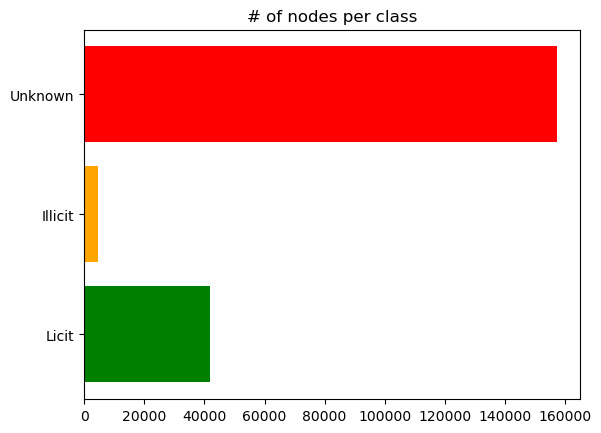

In [3]:
# Add class names for easy understanding
# reformat classes 0:licit, 1:illicit, 2:unknow
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})
# See repartition of nodes per class
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh([ 'Licit','Illicit', 'Unknown'], group_class['txId'].values, color=['g', 'orange', 'r'] )

In [4]:
# View node features
# Data is each node is a transaction ID, and edges are a bit weird, but its like a "previous transaction" edge type
# colume 0 = transaction id
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [5]:
# See edges
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


## Merge dataset
### Merge features with classes

In [6]:
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


## Edge Index: Map trans IDs to Node IDs

In [7]:
# Setup trans ID to node ID mapping
nodes = df_merge[0].values

map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

# Create edge df that has transID mapped to nodeIDs
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
edges.txId2 = edges.txId2.map(map_id)

edges = edges.astype(int)

edge_index = np.array(edges.values).T #convert into an array
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous() # create a tensor

print("shape of edge index is {}".format(edge_index.shape))
edge_index

shape of edge index is torch.Size([2, 234355])


tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

## Set all Edge weights to 1

In [8]:
#create weights tensor with same shape of edge_index
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double)

## Labels

In [9]:
# Define labels
labels = df_merge['class'].values
print("lables", np.unique(labels))
labels

lables [0 1 2]


array([2, 0, 0, ..., 2, 2, 2])

## Node Features

In [10]:
# mapping txIds to corresponding indices, to pass node features to the model

node_features = df_merge.drop(['txId'], axis=1).copy()
# node_features[0] = node_features[0].map(map_id) # Convert transaction ID to node ID \
print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# Drop unwanted columns, 0 = transID, 1=time period, class = labels
node_features = node_features.drop(columns=[0, 1, 'class'])

# Convert to tensor
node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)# drop unused columns
node_features_t

unique= [2 0 1]


tensor([[-0.1685,  0.2709, -0.0914,  ...,  1.1516,  1.5197,  1.5214],
        [-0.1708, -0.1314,  1.0186,  ..., -0.1221, -0.3800, -0.3793],
        [ 1.3052, -0.2106, -1.7564,  ..., -0.1310,  0.0070,  0.0178],
        ...,
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1433, -0.1588, -1.2014,  ..., -0.0975, -0.1206, -0.1198]],
       dtype=torch.float64)

## Train and Test data split

In [11]:
# Create a known vs unknown mask
train_idx, valid_idx = train_test_split(classified_idx.values, test_size=0.15)
print("train_idx size {}".format(len(train_idx)))
print("tets_idx size {}".format(len(valid_idx)))

train_idx size 39579
tets_idx size 6985


## Convert to PyG data format

In [12]:
from torch_geometric.data import Data, DataLoader
data_train = Data(x=node_features_t, edge_index=edge_index, edge_attr=weights,
                               y=torch.tensor(labels, dtype=torch.double))
# Add in the train and valid idx
data_train.train_idx = train_idx
data_train.valid_idx = valid_idx
data_train.test_idx = unclassified_idx

## Train and validate

In [13]:
# Set training arguments, set prebuild=True to use builtin PyG models otherwise False
args={"epochs":200,
      'lr':0.01,
      'weight_decay':1e-5,
      'prebuild':True,
      'heads':2,
      'hidden_dim': 128,
      'dropout': 0.5
      }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model = GATv2modif(data_train.num_node_features,  args['hidden_dim'], 1,args)
print("Custom GATv2 implemented")
model.double().to(device)

Custom GATv2 implemented


GATv2modif(
  (conv1): baseGATv2(165, 128)
  (conv2): baseGATv2(256, 128)
  (post_mp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [15]:
# Push data to GPU
data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gat = GnnTrainer(model)
gnn_trainer_gat.train(data_train, optimizer, criterion, scheduler, args)
gnn_trainer_gat.save_metrics("CGATv2modif.results", path=FOLDERNAME + "/save_results/")
gnn_trainer_gat.save_model("CGATv2modif.pth", path=FOLDERNAME + "/save_results/")

epoch: 0 - loss: 0.7923 - accuracy train: 0.4795 -accuracy valid: 0.4733  - val roc: 0.4957  - val f1micro: 0.4733


/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/ho

epoch: 5 - loss: 0.4466 - accuracy train: 0.9027 -accuracy valid: 0.9009  - val roc: 0.5639  - val f1micro: 0.9009


/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/ho

epoch: 10 - loss: 0.3812 - accuracy train: 0.9027 -accuracy valid: 0.9009  - val roc: 0.5947  - val f1micro: 0.9009


/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/ho

epoch: 15 - loss: 0.3501 - accuracy train: 0.9025 -accuracy valid: 0.9009  - val roc: 0.6082  - val f1micro: 0.9009


/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 20 - loss: 0.3283 - accuracy train: 0.9026 -accuracy valid: 0.9008  - val roc: 0.6455  - val f1micro: 0.9008


/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 25 - loss: 0.3086 - accuracy train: 0.9025 -accuracy valid: 0.9006  - val roc: 0.6543  - val f1micro: 0.9006


/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 30 - loss: 0.2948 - accuracy train: 0.9026 -accuracy valid: 0.9008  - val roc: 0.6827  - val f1micro: 0.9008
epoch: 35 - loss: 0.2852 - accuracy train: 0.9068 -accuracy valid: 0.9004  - val roc: 0.6856  - val f1micro: 0.9004
epoch: 40 - loss: 0.2767 - accuracy train: 0.9076 -accuracy valid: 0.9052  - val roc: 0.7108  - val f1micro: 0.9052
epoch: 45 - loss: 0.2688 - accuracy train: 0.9108 -accuracy valid: 0.9079  - val roc: 0.7399  - val f1micro: 0.9079
epoch: 50 - loss: 0.2639 - accuracy train: 0.9117 -accuracy valid: 0.9104  - val roc: 0.7393  - val f1micro: 0.9104
epoch: 55 - loss: 0.2567 - accuracy train: 0.9140 -accuracy valid: 0.9097  - val roc: 0.7473  - val f1micro: 0.9097
epoch: 60 - loss: 0.2555 - accuracy train: 0.9147 -accuracy valid: 0.9120  - val roc: 0.7411  - val f1micro: 0.9120
epoch: 65 - loss: 0.2489 - accuracy train: 0.9163 -accuracy valid: 0.9131  - val roc: 0.7544  - val f1micro: 0.9131
epoch: 70 - loss: 0.2496 - accuracy train: 0.9171 -accuracy valid: 0.912

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Load one model
m1 = GATv2modif(data_train.num_node_features, args['hidden_dim'], 1, args).to(device).double()
m1.load_state_dict(torch.load(FOLDERNAME + "/save_results/" + "CGATv2modif.pth"))
gnn_t2 = GnnTrainer(m1)
output = gnn_t2.predict(data=data_train, unclassified_only=False)
output

{'pred_scores': array([2.69769693e-03, 8.52955497e-02, 1.21417999e-01, ...,
        7.63283134e-06, 9.98836853e-01, 3.13373892e-02]),
 'pred_labels': array([False, False, False, ..., False,  True, False])}

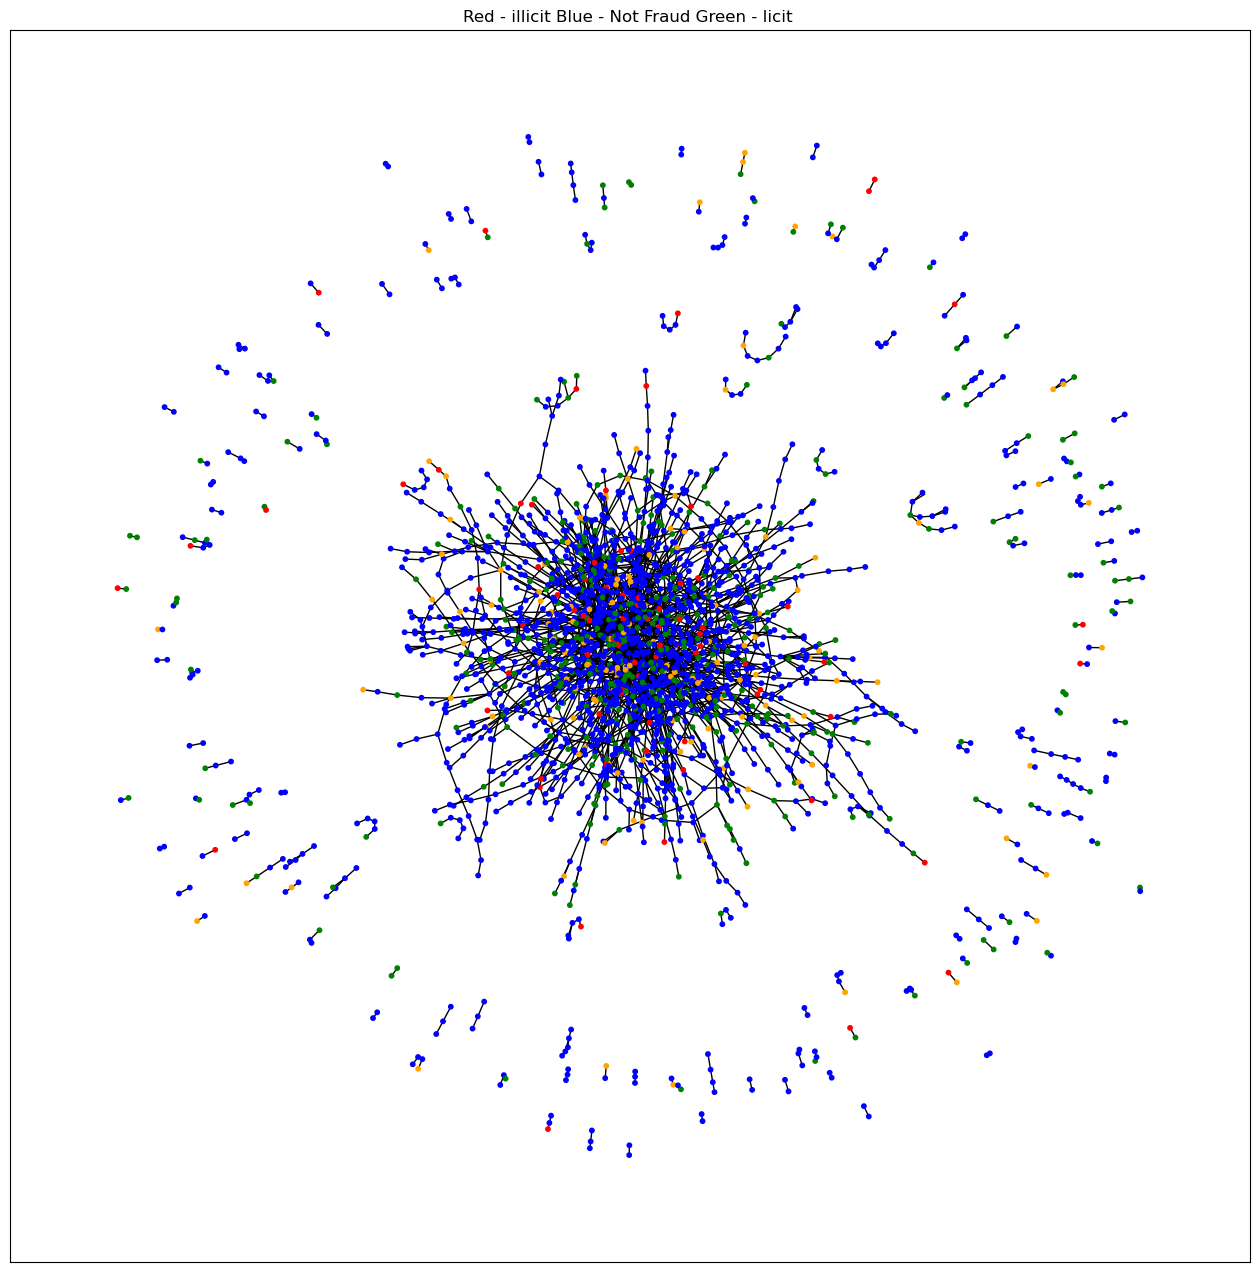

In [17]:
# Get index for one time period
time_period = 30
sub_node_list = df_merge.index[df_merge.loc[:, 1] == time_period].tolist()

# Fetch list of edges for that time period
edge_tuples = []
for row in data_train.edge_index.view(-1, 2).numpy():
  if (row[0] in sub_node_list) | (row[1] in sub_node_list):
    edge_tuples.append(tuple(row))
len(edge_tuples)

# Fetch predicted results for that time period
node_color = []
for node_id in sub_node_list:
  if node_id in classified_illicit_idx: #
     label = "red" # fraud
  elif node_id in classified_licit_idx:
     label = "green" # not fraud
  else:
    if output['pred_labels'][node_id]:
      label = "orange" # Predicted fraud
    else:
      label = "blue" # Not fraud predicted

  node_color.append(label)

# Setup networkx graph
G = nx.Graph()
G.add_edges_from(edge_tuples)

# Plot the graph
plt.figure(3,figsize=(16,16))
plt.title("Red - illicit Blue - Not Fraud Green - licit ")
nx.draw_networkx(G, nodelist=sub_node_list, node_color=node_color, node_size=10, with_labels=False)